## Predicción con método Monte Carlo
En el presente código se implementan la predicción de V y Q usando el método Monte Carlo en su versión *Every Visit*. Es importante recordar que una tarea de predicción en aprendizaje por refuerzo, consiste en intentar calcular los valores de V o Q al seguir una política $\pi$.

#### Funciones a usar

In [144]:
import numpy as np
import collections
import gymnasium as gym

Políticas que se usarán

In [145]:
# Política simple a seguir en cada episodio
def politica_simple(estado):
    accion = 0 if estado[0] > 19 else 1
    return accion

# Política estocástica a seguir en cada episodio
def politica_estocastica(estado):
    probabilidades = [0.9, 0.1] if estado[0] > 15 else [0.1, 0.9]
    accion = np.random.choice(np.arange(2), p=probabilidades)
    return accion

Funciones de predicción y de generación de episodios

In [146]:
# Generar episodio
def GenerarEpisodio(ambiente, politica):
    episodio = []
    estado = ambiente.reset()[0]
    while True:
        accion = politica(estado)
        nuevo_estado, recompensa, is_done, trunc, info = ambiente.step(accion)
        episodio.append((estado, accion, recompensa))
        estado = nuevo_estado
        if is_done:
            break
    return episodio

# Función para predecir V con Monte Carlo 
def Prediccion_V_MonteCarlo(ambiente, num_episodios, GenerarEpisodio, politica, GAMMA=1.0):
    suma_retornos = collections.defaultdict(float)
    N = collections.defaultdict(int) # Número de veces que se ha visitado un estado
    V = collections.defaultdict(float) # Predicciones de el valor de los estados visitados
    
    for no_episodio in range(1, num_episodios+1): # Generar un número de epsodios
        episodio = GenerarEpisodio(ambiente, politica)
        estados, acciones, recompensas = zip(*episodio)
        
        for i, estado in enumerate(estados): # Calcular predicciones de V en su versión 'Every-Visit'
                                                # Agregar <if estado not in estados[:i]: > para 'First-Visit'
            suma_retornos[estado] += sum(r*GAMMA**k for k, r in enumerate(recompensas[i:])) # Si se observa, el retorno es la suma de las recompensas desde el estado
                                                                                            # actual hasta el final del episodio, no se toman en cuenta todos desde el inicio
            N[estado] += 1.0
            V[estado] = suma_retornos[estado]/N[estado]
    
    return V

# Función para predecir Q con Monte Carlo
def Prediccion_Q_MonteCarlo(ambiente, num_episodios, GenerarEpisodio, politica, GAMMA=1.0):
    suma_retornos = collections.defaultdict(lambda: np.zeros(ambiente.action_space.n))
    N = collections.defaultdict(lambda: np.zeros(ambiente.action_space.n))
    Q = collections.defaultdict(lambda: np.zeros(ambiente.action_space.n))
    
    for no_episodio in range(1, num_episodios+1):
        episodio = GenerarEpisodio(ambiente, politica)
        estados, acciones, recompensas = zip(*episodio)
        
        for i, estado in enumerate(estados):
            suma_retornos[estado][acciones[i]] += sum(r*GAMMA**k for k, r in enumerate(recompensas[i:]))
            N[estado][acciones[i]] += 1.0
            Q[estado][acciones[i]] = suma_retornos[estado][acciones[i]]/N[estado][acciones[i]]
    
    return Q

Función para graficar en 3D

In [147]:
# source  https://github.com/udacity/deep-reinforcement-learning/blob/master/monte-carlo/plot_utils.py

import matplotlib.pyplot as plt

def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)

        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)
        ax.set_zlim(-1, 1);
        return surf

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('As Usable')
    surf = get_figure(True, ax)
    fig.colorbar(surf, shrink=0.5, aspect=15)
    plt.show()

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('As No Usable')
    surf = get_figure(False, ax)
    fig.colorbar(surf, shrink=0.5, aspect=15)
    plt.show()

#### Predicción de V

##### Predicción con política determinista

In [148]:
ambiente = gym.make('Blackjack-v1')
num_episodios = 500000 # Según el libro 500,000 episodios es suficiente para converger
GAMMA = 1.0

V = Prediccion_V_MonteCarlo(ambiente, num_episodios, GenerarEpisodio, politica_simple, GAMMA)
print(V)

c:\PYTHON\Python387\lib\site-packages\gymnasium\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


defaultdict(<class 'float'>, {(20, 2, False): 0.6326203208556149, (13, 1, True): -0.4539170506912442, (17, 1, True): -0.4992887624466572, (14, 1, False): -0.6807492195629553, (20, 1, False): 0.1324582338902148, (7, 10, False): -0.5540856031128405, (12, 10, False): -0.5695909015624138, (18, 10, False): -0.725590153393956, (15, 10, False): -0.651689900712065, (11, 9, False): -0.02455661664392906, (14, 9, False): -0.5918492729879172, (21, 5, True): 0.9671921602045164, (10, 5, False): -0.0674217907227616, (20, 5, False): 0.6658294778585592, (7, 1, False): -0.6206896551724138, (9, 1, False): -0.6180645161290322, (16, 4, False): -0.6780781949037152, (20, 10, False): 0.4425689307330195, (14, 5, False): -0.600919348098621, (18, 5, False): -0.7066642716005029, (17, 2, False): -0.688585839716047, (21, 2, False): 0.8836614676553312, (6, 10, False): -0.5520720720720721, (16, 10, False): -0.672736933629601, (12, 4, False): -0.5376795580110497, (18, 8, False): -0.6872827081427264, (14, 4, True): -0.

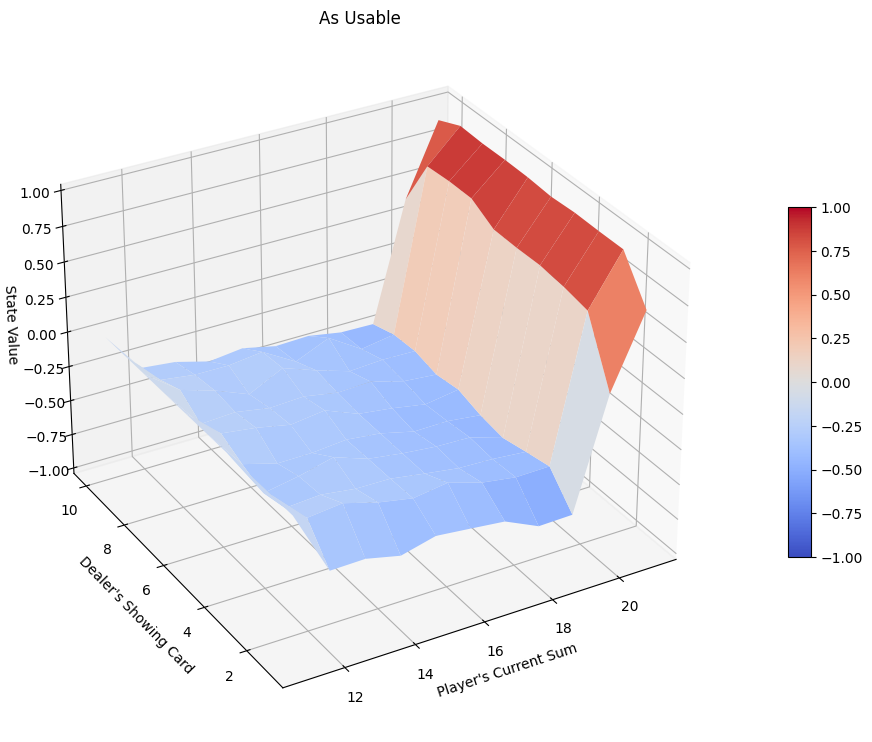

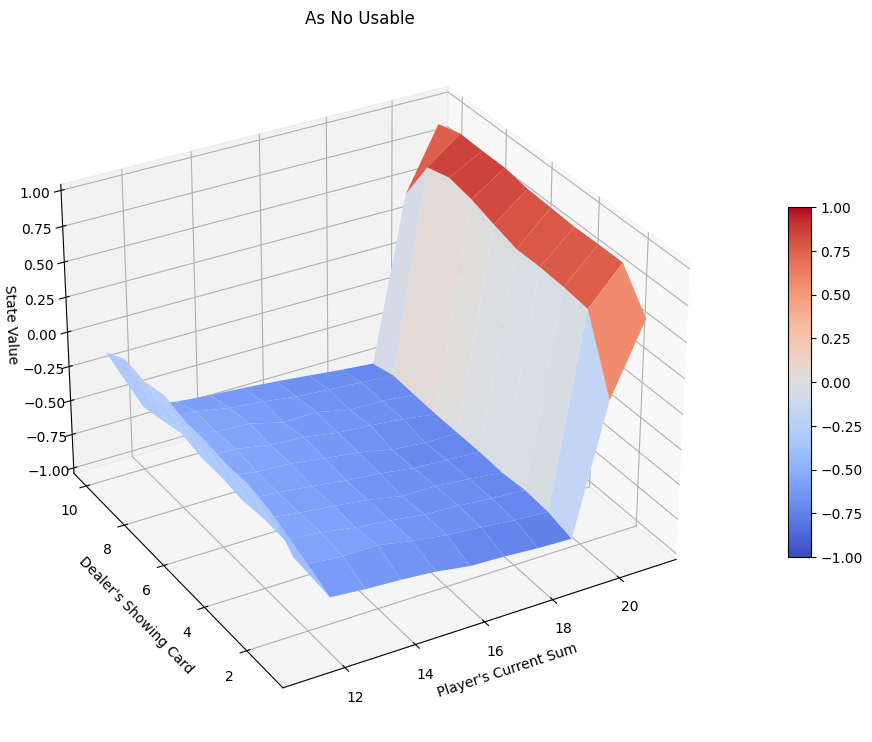

In [149]:
plot_blackjack_values(V)

##### Predicción con política estocástica

In [150]:
ambiente = gym.make('Blackjack-v1')
num_episodios = 500000 # Según el libro 500,000 episodios es suficiente para converger
GAMMA = 1.0

V = Prediccion_V_MonteCarlo(ambiente, num_episodios, GenerarEpisodio, politica_estocastica, GAMMA)
print(V)

defaultdict(<class 'float'>, {(14, 8, False): -0.42672998643147897, (20, 8, False): 0.6197379912663755, (21, 4, True): 0.890295358649789, (13, 1, False): -0.6223055295220243, (14, 1, False): -0.6574882471457354, (13, 10, True): -0.3146708138932089, (20, 10, True): 0.37631394533987383, (19, 4, False): 0.30341113105924594, (19, 10, False): -0.0957963598678671, (21, 10, False): 0.6972466033425514, (13, 4, False): -0.32361716777599264, (14, 10, False): -0.5424786088876622, (18, 3, True): 0.15538461538461537, (12, 10, False): -0.4729282421089963, (13, 10, False): -0.5093005736802457, (20, 10, False): 0.30494276566817247, (8, 10, False): -0.3759145738580186, (11, 3, False): 0.10609585853885528, (19, 3, False): 0.2896551724137931, (20, 7, False): 0.6310798946444249, (20, 3, False): 0.5027467659046606, (15, 5, False): -0.3901639344262295, (16, 3, False): -0.2712577502214349, (18, 6, False): 0.20218308112130984, (10, 4, False): 0.10788608981380066, (17, 4, False): -0.11935110081112399, (12, 8, 

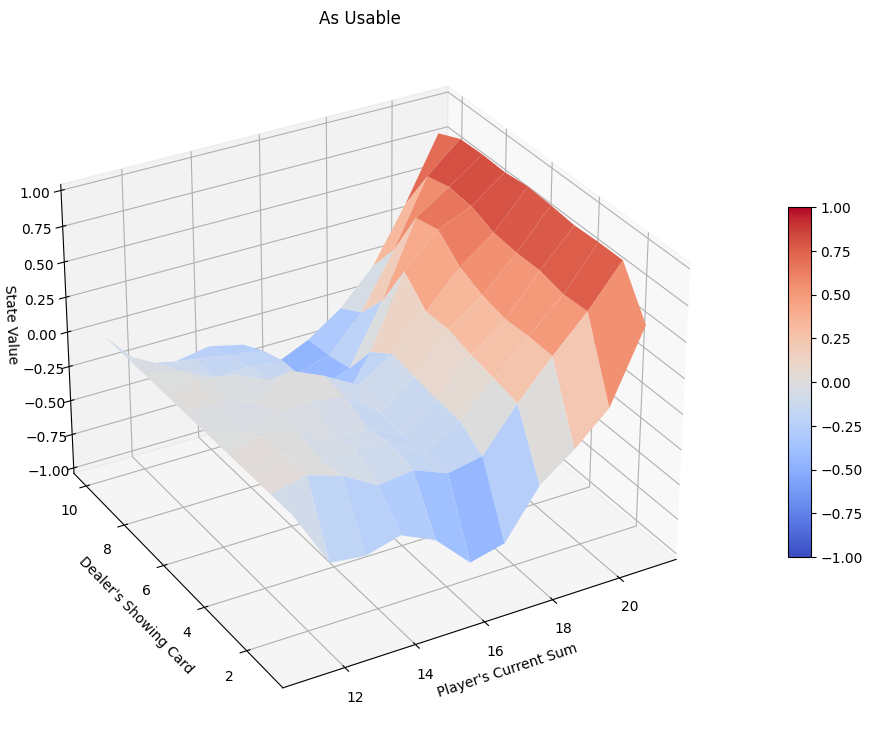

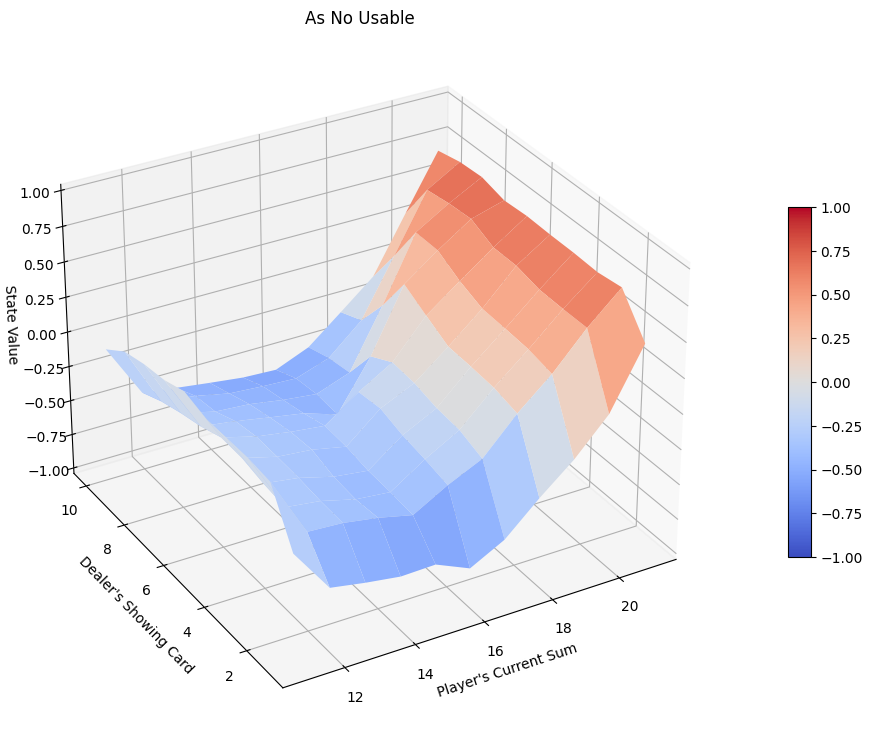

In [151]:
plot_blackjack_values(V)

#### Predicción de Q

##### Predicción con política estocástica

In [152]:
ambiente = gym.make('Blackjack-v1')
num_episodios = 500000 # Según el libro 500,000 episodios es suficiente para converger
GAMMA = 1.0

Q = Prediccion_Q_MonteCarlo(ambiente, num_episodios, GenerarEpisodio, politica_estocastica, GAMMA)
print(Q)

defaultdict(<function Prediccion_Q_MonteCarlo.<locals>.<lambda> at 0x0000016AF4B4DEE0>, {(17, 6, False): array([ 0.00366492, -0.52045455]), (18, 10, True): array([-0.26584362, -0.22393822]), (13, 1, False): array([-0.81995134, -0.60833122]), (18, 1, False): array([-0.37259816, -0.73176471]), (21, 10, True): array([ 0.92201774, -0.02850356]), (14, 6, True): array([-0.27272727,  0.03463203]), (14, 6, False): array([-0.11607143, -0.34729627]), (20, 6, False): array([ 0.70859133, -0.86294416]), (8, 10, False): array([-0.57489879, -0.37088036]), (12, 10, False): array([-0.59152443, -0.46094767]), (13, 10, False): array([-0.53661465, -0.49777495]), (19, 10, False): array([-0.02502659, -0.79094541]), (21, 6, True): array([0.98949028, 0.11261261]), (15, 6, False): array([-0.05527638, -0.40805985]), (16, 6, False): array([-0.14443885, -0.48098434]), (11, 6, False): array([-0.22689076,  0.15838207]), (12, 3, False): array([-0.17257683, -0.31267678]), (16, 3, False): array([-0.25553013, -0.424507

Ejemplo de cómo acceder a los diccionarios hechos para Q. La fila es el estado y la columna es la acción, son dos columnas (0 y 1)

In [153]:
print(Q[(12, 1, False)][0])

-0.7751196172248804


Obtener V del Q calculado usando la ecuación $$ V_{\pi}(s) = \sum_{a}\pi(a|s).Q_{\pi}(s|a) $$

In [154]:
V_from_Q = dict((estado, (estado[0]>15)*(np.dot([0.9, 0.1], acciones)) + (estado[0]<=15)*(np.dot([0.9, 0.1], acciones))) for estado, acciones in Q.items())

Visualización

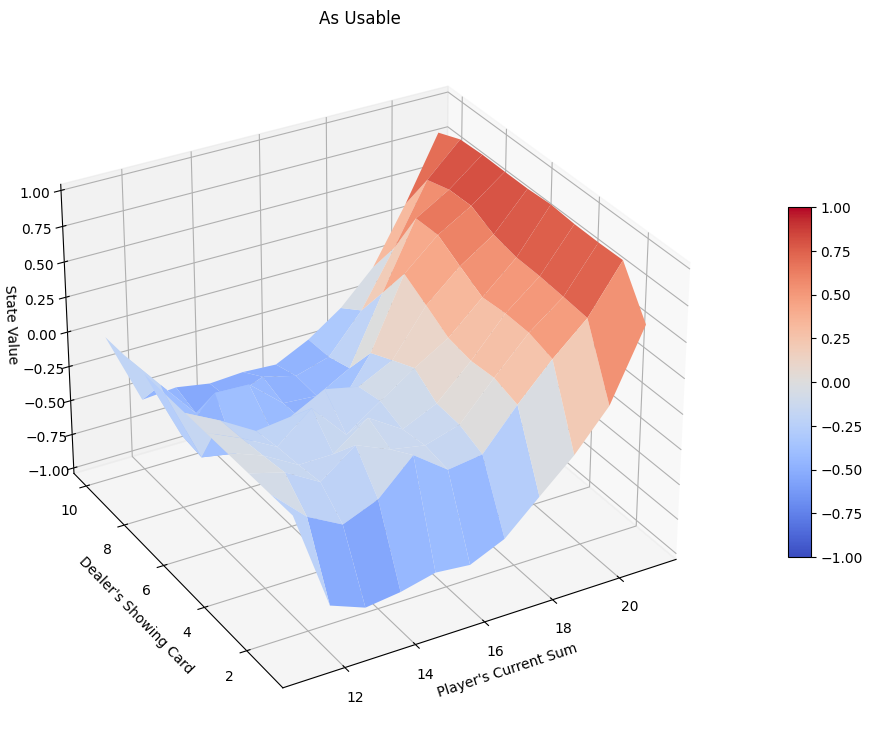

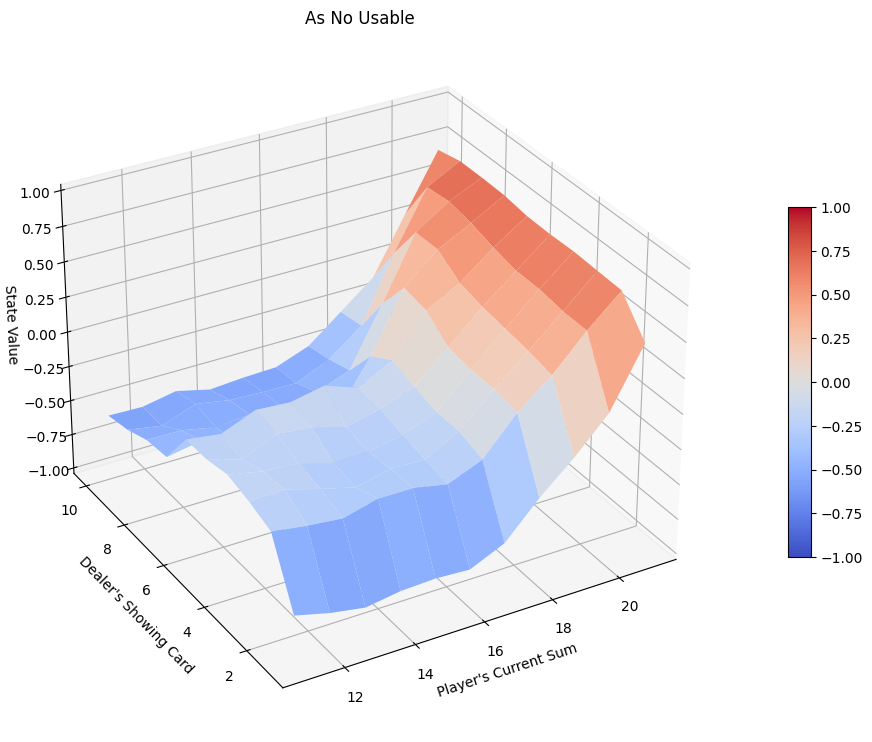

In [155]:
plot_blackjack_values(V_from_Q)